# Unit 5 - Financial Planning

In [40]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from alpaca_trade_api import TimeFrame
from MCForecastTools import MCSimulation

%matplotlib inline

In [41]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)


## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [42]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [43]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"


In [44]:
# Fetch current BTC price
btc_value = requests.get(btc_url).json()
current_btc_value = btc_value['data']['1']['quotes']['CAD']['price']

# Fetch current ETH price
eth_value = requests.get(eth_url).json()
current_eth_value = eth_value['data']['1027']['quotes']['CAD']['price']

# Compute current value of my crpto
my_btc_value = current_btc_value * my_btc
my_eth_value = current_eth_value * my_eth

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $62652.10
The current value of your 5.3 ETH is $19184.53


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [45]:
# Set current amount of shares
my_agg = 200
my_spy = 50


In [46]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [57]:
# Format current date as ISO format
today = pd.Timestamp("2022-03-11", tz="America/New_York").isoformat()

# Set the tickers
ticker = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
def ticker_data(ticker):
    end_date = (pd.Timestamp(today, tz="America/New_York") - pd.DateOffset(1)).isoformat()
    start_date = (pd.Timestamp(today, tz="America/New_York") - pd.DateOffset(1)).isoformat()
    data = api.get_bars(
        ticker,
        tradeapi.TimeFrame.Day,
        start = start_date,
        end = end_date,
        adjustment='raw'
    ).df
    
    data = data.drop(['trade_count', 'vwap', 'volume'], axis='columns')
    return data

# call function for each ticker
spy = ticker_data('SPY')
agg = ticker_data('AGG')

# concatenate the ticker data and set keys for multi-indexing along columns
data = pd.concat([spy, agg], keys=['SPY', 'AGG'], axis='columns', join='inner')

# Preview DataFrame
data

SPY                             AGG          \
                             open    high     low   close    open    high   
timestamp                                                                   
2022-03-10 05:00:00+00:00  422.73  426.43  420.44  425.48  108.65  108.68   

                                           
                              low   close  
timestamp                                  
2022-03-10 05:00:00+00:00  108.25  108.43

In [59]:
# Pick AGG and SPY close prices
agg_close_price = float(data["AGG"]["close"])
spy_close_price = float(data["SPY"]["close"])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $108.43
Current SPY closing price: $425.48


In [60]:
# Compute the current value of shares
my_agg_value = agg_close_price * my_agg
my_spy_value = spy_close_price * my_spy

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $21274.00
The current value of your 200 AGG shares is $21686.00


### Savings Health Analysis

In [61]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
assets = {
    'Amount': { 
        'crypto': my_btc_value + my_eth_value,
        'shares':  my_spy_value + my_agg_value
    },
}


# Create savings DataFrame
df_savings = pd.DataFrame(assets)


# Display savings DataFrame
print(df_savings)

            Amount
crypto  81836.6344
shares  42960.0000


array([<AxesSubplot:ylabel='Amount'>], dtype=object)

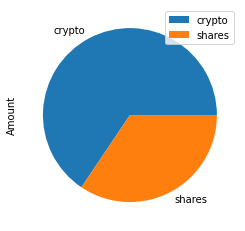

In [62]:
# Plot savings pie chart
df_savings.plot(kind='pie', subplots=True)

In [63]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings['Amount'].sum()

# Validate saving health
if total_savings > emergency_fund:
    print("You have enough savings for emergency fund!")
elif total_savings == emergency_fund:
    print("You have reached to your emergency fund goal!")
else:
    print(f"You still need ${emergency_fund - total_savings :0.2F} to reach your emergency fund")

You have enough savings for emergency fund!


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [68]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
#start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
#end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [78]:
# Get 5 years' worth of historical data for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
def df_stock_data(ticker):
    end_date = (pd.Timestamp("today", tz="America/New_York") - pd.DateOffset(1)).isoformat()
    start_date = (pd.Timestamp("today", tz="America/New_York") - pd.DateOffset(1500)).isoformat()
    stock_data = api.get_bars(
        ticker,
        tradeapi.TimeFrame.Day,
        start = start_date,
        end = end_date,
        adjustment='raw'
    ).df

    stock_data = stock_data.drop(['trade_count', 'vwap', 'volume'], axis='columns')
    return stock_data

# call function for each ticker
spy = df_stock_data('SPY')
agg = df_stock_data('AGG')

# concatenate the ticker data and set keys for multi-indexing along columns
stock_data = pd.concat([spy, agg], keys=['SPY', 'AGG'], axis='columns', join='inner')
stock_data



SPY                               AGG  \
                              open    high       low   close    open   
timestamp                                                              
2018-02-12 05:00:00+00:00  263.890  267.01  261.6644  265.32  106.74   
2018-02-13 05:00:00+00:00  264.000  266.62  263.3100  266.05  106.79   
2018-02-14 05:00:00+00:00  264.400  270.00  264.3000  269.67  106.57   
2018-02-15 05:00:00+00:00  271.560  273.04  268.7700  272.93  106.56   
2018-02-16 05:00:00+00:00  272.270  275.32  272.0355  273.16  106.85   
...                            ...     ...       ...     ...     ...   
2022-03-14 04:00:00+00:00  420.975  424.55  415.7900  417.00  107.78   
2022-03-15 04:00:00+00:00  419.900  426.84  418.4200  426.17  107.83   
2022-03-16 04:00:00+00:00  429.940  435.68  424.8000  435.62  107.63   
2022-03-17 04:00:00+00:00  433.700  441.07  433.1900  441.07  107.87   
2022-03-18 04:00:00+00:00  438.200  444.86  437.2200  444.52  107.95   

                                                       
                               high       low   close  
timestamp                                              
2018-02-12 05:00:00+00:00  106.9450  106.6632  106.79  
2018-02-13 05:00:00+00:00  106.9100  106.7000  106.82  
2018-02-14 05:00:00+00:00  106.6600  106.4039  106.46  
2018-02-15 05:00:00+00:00  106.7272  106.5300  106.59  
2018-02-16 05:00:00+00:00  106.8750  106.7100  106.80  
...                             ...       ...     ...  
2022-03-14 04:00:00+00:00  107.8160  107.3600  107.36  
2022-03-15 04:00:00+00:00  107.9200  107.4300  107.60  
2022-03-16 04:00:00+00:00  107.7300  107.0032  107.68  
2022-03-17 04:00:00+00:00  108.0600  107.7300  107.86  
2022-03-18 04:00:00+00:00  108.1400  107.9203  108.10  

[1033 rows x 8 columns]

In [79]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
num_sims = 500
weights = [0.4,0.6]

MC_Portfolio = MCSimulation(
    portfolio_data = stock_data,
    num_simulation = num_sims,
    weights=weights,
    num_trading_days = 252*30
)


In [80]:
# Printing the simulation input data
MC_Portfolio.portfolio_data.head()


SPY                                         \
                             open    high       low   close daily_return   
timestamp                                                                  
2018-02-12 05:00:00+00:00  263.89  267.01  261.6644  265.32          NaN   
2018-02-13 05:00:00+00:00  264.00  266.62  263.3100  266.05     0.002751   
2018-02-14 05:00:00+00:00  264.40  270.00  264.3000  269.67     0.013606   
2018-02-15 05:00:00+00:00  271.56  273.04  268.7700  272.93     0.012089   
2018-02-16 05:00:00+00:00  272.27  275.32  272.0355  273.16     0.000843   

                              AGG                                           
                             open      high       low   close daily_return  
timestamp                                                                   
2018-02-12 05:00:00+00:00  106.74  106.9450  106.6632  106.79          NaN  
2018-02-13 05:00:00+00:00  106.79  106.9100  106.7000  106.82     0.000281  
2018-02-14 05:00:00+00:00  106.57  106.6600  106.4039  106.46    -0.003370  
2018-02-15 05:00:00+00:00  106.56  106.7272  106.5300  106.59     0.001221  
2018-02-16 05:00:00+00:00  106.85  106.8750  106.7100  106.80     0.001970

In [81]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_Portfolio.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


c:\Users\samro\Fintech\API_Homework\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.997343,0.989474,0.998553,0.993758,0.997165,1.004011,1.008007,1.003359,0.995610,0.993395,...,0.999437,0.993474,0.991329,0.997036,1.000779,1.003324,1.005135,1.007840,0.996072,0.995183
2,1.002546,0.985286,0.991807,0.998778,1.003742,1.006052,1.011885,0.999080,0.989818,0.987647,...,0.998019,0.997109,0.987455,0.999406,1.011033,1.004314,1.010542,0.996590,0.998626,1.005700
3,1.003690,0.977838,0.989466,1.007393,0.998582,1.000978,1.002550,0.995396,0.984540,0.992275,...,1.000710,0.996427,0.982731,1.004284,1.013877,1.009084,1.013484,0.997918,0.986009,1.008797
4,0.998322,0.980456,0.994001,1.014087,1.000040,0.999626,1.005884,1.002128,0.986054,1.001253,...,1.003946,1.006005,0.988345,1.011885,1.007451,1.005788,1.009882,0.999609,0.991547,1.007013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,7.459637,8.155468,5.249608,11.140033,4.516069,6.953412,3.773996,6.162472,2.897686,5.126005,...,7.807078,9.521998,5.008389,3.682935,5.060490,4.246026,8.754657,4.243533,4.692733,7.103066
7557,7.476076,8.159228,5.248381,11.178497,4.551840,6.898070,3.780578,6.096432,2.895205,5.110256,...,7.816414,9.566870,4.980702,3.691622,5.063235,4.251651,8.771598,4.241246,4.672197,7.133427
7558,7.421761,8.080852,5.216941,11.166250,4.537825,6.908922,3.785488,6.010784,2.888918,5.150433,...,7.905801,9.577857,4.934815,3.654298,5.059774,4.271261,8.815872,4.251548,4.713351,7.117817
7559,7.485519,8.216267,5.258331,11.208913,4.560947,6.868567,3.773847,5.940596,2.883306,5.210529,...,7.825720,9.626002,4.951308,3.637139,5.010976,4.290143,8.803794,4.262974,4.728100,7.167979


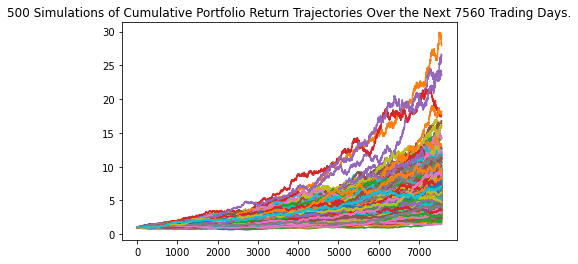

In [82]:
# Plot simulation outcomes
line_plot = MC_Portfolio.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

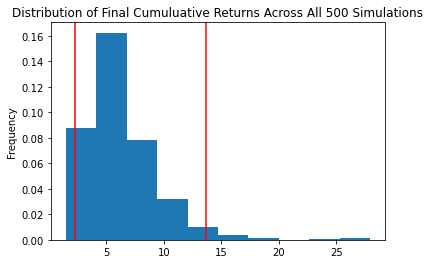

In [83]:
# Plot probability distribution and confidence intervals
MC_Portfolio.plot_distribution()

### Retirement Analysis

In [84]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_stats = MC_Portfolio.summarize_cumulative_return()

# Print summary statistics
summary_stats

count           500.000000
mean              6.249265
std               3.227166
min               1.465551
25%               4.233843
50%               5.518419
75%               7.394464
max              27.950819
95% CI Lower      2.261993
95% CI Upper     13.690992
Name: 7560, dtype: float64

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [85]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(summary_stats[8]*initial_investment,2)
ci_upper = round(summary_stats[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $45239.86 and $273819.84


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [86]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(summary_stats[8]*initial_investment,2)
ci_upper = round(summary_stats[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $67859.79 and $410729.76


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [88]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
num_sims = 500
weights = [0.4,0.6]

MC_Portfolio1 = MCSimulation(
    portfolio_data = stock_data,
    num_simulation = num_sims,
    weights=weights,
    num_trading_days = 252*5
)

In [89]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_Portfolio1.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


c:\Users\samro\Fintech\API_Homework\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.007600,0.998812,1.004501,1.012371,0.999606,1.004064,1.002135,0.999791,0.995078,1.005635,...,0.993253,0.998442,1.006743,1.002885,0.999163,1.008492,0.996364,1.002445,0.991314,0.997745
2,1.014429,1.003511,0.995803,1.019989,1.009394,1.007154,1.000995,0.999992,0.993339,1.006960,...,0.988910,1.004258,1.005630,1.004455,0.998087,1.005948,0.995247,1.009945,0.995408,0.997837
3,1.009698,1.002051,1.002571,1.023546,1.009939,1.005115,1.003619,0.999021,0.995808,1.009957,...,0.987457,1.005177,1.007557,0.997811,0.995505,1.014943,0.993546,1.006701,1.011639,0.996398
4,1.002467,1.001905,0.993825,1.026449,1.019228,1.015127,1.004036,0.992392,0.991627,1.017115,...,0.980580,1.019708,1.011450,1.005161,0.995199,1.006004,0.993539,1.012062,1.011162,1.007540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.437362,1.192178,1.185999,1.505226,1.450450,0.879671,1.330450,1.458277,1.643566,1.283931,...,1.294085,1.530267,1.569992,1.507469,1.528816,1.016133,1.323985,0.974740,1.261541,1.457222
1257,1.436124,1.195900,1.192561,1.500224,1.443982,0.884972,1.331212,1.470502,1.645268,1.300125,...,1.297982,1.531169,1.572434,1.502550,1.531617,1.019770,1.322946,0.968206,1.266072,1.464935
1258,1.443798,1.200689,1.190031,1.489218,1.443224,0.887199,1.330999,1.473178,1.632114,1.290524,...,1.305755,1.521832,1.579051,1.511503,1.548485,1.026483,1.323352,0.965886,1.269624,1.474836
1259,1.461142,1.205370,1.190530,1.487615,1.456710,0.890298,1.328455,1.475302,1.632964,1.296038,...,1.322713,1.536920,1.581906,1.503420,1.548475,1.012117,1.320172,0.965470,1.261624,1.469944


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

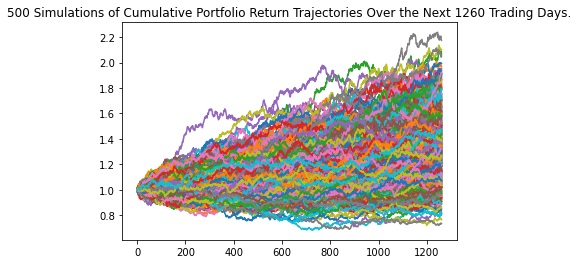

In [90]:
# Plot simulation outcomes
MC_Portfolio1.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

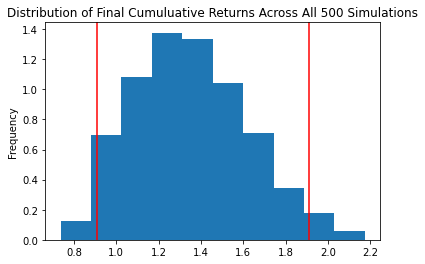

In [91]:
# Plot probability distribution and confidence intervals
MC_Portfolio1.plot_distribution()

In [92]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_stats_1 = MC_Portfolio1.summarize_cumulative_return()

# Print summary statistics
summary_stats_1

count           500.000000
mean              1.349998
std               0.268675
min               0.736130
25%               1.149767
50%               1.330939
75%               1.527175
max               2.174298
95% CI Lower      0.906676
95% CI Upper      1.910286
Name: 1260, dtype: float64

In [94]:
# Set initial investment
initial_investment = 20000 * 3

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(summary_stats[8]*initial_investment,2)
ci_upper = round(summary_stats[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 30 years will end within in the range of $135719.58 and $821459.53


### Ten Years Retirement Option

In [96]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
num_sims = 500
weights = [0.4,0.6]

MC_Portfolio2 = MCSimulation(
    portfolio_data = stock_data,
    num_simulation = num_sims,
    weights=weights,
    num_trading_days = 252*10
)

In [97]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_Portfolio2.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


c:\Users\samro\Fintech\API_Homework\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.004007,1.005036,1.001349,1.003151,0.998948,1.007942,1.000749,1.003758,1.000410,0.995687,...,1.009027,0.991855,0.996756,0.997482,0.994404,1.008190,1.008123,0.997840,0.997351,0.995230
2,1.007256,0.999183,1.005653,0.994101,1.012073,1.011009,0.999849,0.998522,0.999914,0.999998,...,1.020459,0.990933,1.000931,0.997799,0.994261,1.009932,1.012904,1.000257,1.000140,0.997619
3,1.012871,1.003509,1.011769,0.982012,1.011624,1.010641,1.000062,0.998435,0.991226,1.001633,...,1.016298,0.998076,1.000893,0.998964,1.005986,1.007997,1.005302,1.001176,1.004715,1.001414
4,1.014509,1.007894,1.012055,0.979997,1.006091,1.006562,0.996579,0.996803,0.989446,1.003469,...,1.023114,0.997191,1.002164,0.994889,0.997546,1.006678,1.002466,1.002039,1.007826,1.004583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.184359,1.516922,2.458266,1.499508,1.263236,2.041643,1.283094,0.899463,1.492332,1.683637,...,1.830738,1.081579,2.727406,1.780546,1.328651,1.995088,1.889441,1.967405,1.877647,1.283799
2517,2.177191,1.523965,2.487423,1.505367,1.261883,2.043167,1.284326,0.894314,1.495947,1.669524,...,1.835807,1.080111,2.746927,1.777007,1.326795,2.010693,1.899477,1.972966,1.856901,1.283560
2518,2.166729,1.523029,2.476419,1.493320,1.270245,2.049949,1.295856,0.890674,1.508394,1.658676,...,1.829887,1.072780,2.777175,1.769704,1.338655,2.037776,1.890995,1.967018,1.866439,1.295223
2519,2.141992,1.520914,2.477617,1.503650,1.271698,2.071799,1.313312,0.887957,1.517421,1.673174,...,1.832851,1.074057,2.777877,1.771322,1.332137,2.036540,1.888489,1.976053,1.872393,1.286752


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

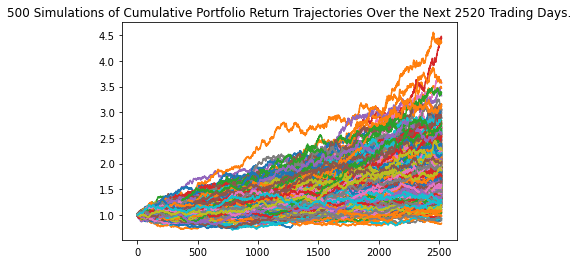

In [98]:
# Plot simulation outcomes
MC_Portfolio2.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

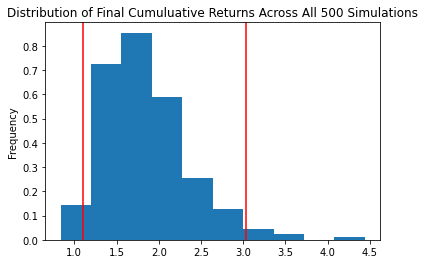

In [100]:
# Plot probability distribution and confidence intervals
MC_Portfolio2.plot_distribution()

In [101]:
# Fetch summary statistics from the Monte Carlo simulation results
new_summary = MC_Portfolio2.summarize_cumulative_return()

# Print summary statistics
new_summary

count           500.000000
mean              1.841905
std               0.507772
min               0.835910
25%               1.477073
50%               1.767460
75%               2.095783
max               4.442529
95% CI Lower      1.098925
95% CI Upper      3.036722
Name: 2520, dtype: float64

In [103]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower = round(new_summary[8]*initial_investment,2)
ci_upper = round(new_summary[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $65935.51 and $182203.34
